# Generate plots of per locus sums of scaled differential selection and average similarity scores

- Plots correspond to Figures 3A, 4A, 5A

In [1]:
# Analysis definitions, constants, helper functions
from utils import *

import matplotlib.pyplot as plt
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

import os
import copy
import warnings
warnings.filterwarnings('ignore')

# Python Optimal Transport package
import ot

In [2]:
# Figures directory
figdir = "figures"
if not os.path.exists(figdir): os.mkdir(figdir)

# Scaled differential selection data variable name
metric = "smooth_flank_1_enr_diff_sel"

# Data
peptide_table_file = 'data/phage-dms-nhp_peptide_table.csv'
sample_table_file  = 'data/phage-dms-nhp_sample_table.csv'
counts_file        = 'data/phage-dms-nhp_counts.csv'
enrichment_file    = 'data/phage-dms-nhp_enrichment.csv'
diff_sel_file      = f'data/phage-dms-nhp_{metric}.csv'

In [3]:
# Construct xarray dataset from CSV files

peptide_table_df = pd.read_csv(peptide_table_file,index_col='peptide_id')
peptide_table_arr = xr.DataArray(data=peptide_table_df, dims=['peptide_id','peptide_metadata'], name='peptide_table')
peptide_table_ds = peptide_table_arr.to_dataset()

sample_table_df  = pd.read_csv(sample_table_file,index_col='sample_id')
sample_table_arr = xr.DataArray(data=sample_table_df, dims=['sample_id','sample_metadata'], name='sample_table')
sample_table_ds = sample_table_arr.to_dataset()

counts_df = pd.read_csv(counts_file,index_col='peptide_id')
counts_df.columns = counts_df.columns.astype(int)
counts_arr = xr.DataArray(data=counts_df, dims=['peptide_id','sample_id'], name='counts')
counts_ds = counts_arr.to_dataset()

enrichment_df = pd.read_csv(enrichment_file,index_col='peptide_id')
enrichment_df.columns = enrichment_df.columns.astype(int)
enrichment_arr = xr.DataArray(data=enrichment_df, dims=['peptide_id','sample_id'], name='enrichment')
enrichment_ds = enrichment_arr.to_dataset()

diff_sel_df = pd.read_csv(diff_sel_file,index_col='peptide_id')
diff_sel_df.columns = diff_sel_df.columns.astype(int)
diff_sel_arr = xr.DataArray(data=diff_sel_df, dims=['peptide_id','sample_id'], name=metric)
diff_sel_ds = diff_sel_arr.to_dataset()

phip_ds = xr.merge([peptide_table_ds, sample_table_ds, counts_ds, enrichment_ds, diff_sel_ds])
phip_ds

<xarray.Dataset>
Dimensions:                      (peptide_id: 24220, peptide_metadata: 4, sample_id: 134, sample_metadata: 11)
Coordinates:
  * peptide_id                   (peptide_id) int64 0 1 2 ... 24837 24838 24839
  * peptide_metadata             (peptide_metadata) object 'Oligo' ... 'is_wt'
  * sample_id                    (sample_id) int64 1511 1549 516 ... 267 186 271
  * sample_metadata              (sample_metadata) object 'Vaccine' ... 'spec...
Data variables:
    peptide_table                (peptide_id, peptide_metadata) object 'aggaa...
    sample_table                 (sample_id, sample_metadata) object 'HBV + 2...
    counts                       (peptide_id, sample_id) float64 0.0 ... 40.0
    enrichment                   (peptide_id, sample_id) float64 0.107 ... 0....
    smooth_flank_1_enr_diff_sel  (peptide_id, sample_id) float64 -0.1056 ... ...

In [4]:
# Cost matrix for escape similarity score
cost_matrix = get_cost_matrix()

In [5]:
# Compute per locus summed scaled differential selection and 
# similarity score for a specified epitope region and sample group
def analyze_region(
    ds,
    region,
    group
):
    region_sums=[]
    region_sim=[]

    for loc in range(epitope_limits[region][0], epitope_limits[region][1]+1):    
        loc_sums=[]
        loc_sim=[]
    
        for sid1 in group:
            esc_data1 = get_loc_escape_data(ds,sid1,loc,metric,False)
            loc_sums.append(np.sum(esc_data1[20:])-np.sum(esc_data1[:20]))
        
            for sid2 in group:
                if sid1>=sid2: continue
                esc_data2 = get_loc_escape_data(ds,sid2,loc,metric,False)
                
                if np.sum(esc_data1)==0 or np.sum(esc_data2)==0:
                    loc_sim.append(0)
                    continue
                
                a = esc_data1/np.sum(esc_data1)
                b = esc_data2/np.sum(esc_data2)
                cost = ot.emd2(a,b,cost_matrix)
                loc_sim.append(1./cost)
            
        region_sums.append(loc_sums)
        region_sim.append(loc_sim)
    
    return region_sums, region_sim

In [6]:
# Plotting function
def plot_sum_diff_sel_boxes(
    region_groups_sums,
    region_groups_sim,
    groups_colors,
    groups_markers,
    groups_labels,
    region,
    ymin_sums=[], ymax_sums=[],
    ymin_sim=None, ymax_sim=None,
    legncol=2,
    draw=True,
    out=None
):
    linew = 2
    Ngroups = len(region_groups_sums)
    
    loc_start = epitope_limits[region][0]
    loc_end   = epitope_limits[region][1]
    title     = f'{epitope_names[region]}: (AA {epitope_limits[region][0]}-{epitope_limits[region][1]})'
    
    xticks=[]
    xlabels=[]
    for i in range(loc_end - loc_start + 1):
        label = loc_start+i
        if label%5 == 0:
            xticks.append(i+1)
            xlabels.append(label)
    
    # compute average of within group similarity scores for each group
    avg_data=[]
    for i in range(Ngroups):
        avg_data.append([np.mean(x) for x in region_groups_sim[i]])
        
    
    fig = plt.figure(figsize=[15,3+3*Ngroups])
    fig.patch.set_facecolor('white')
    gs = fig.add_gridspec(Ngroups+1, hspace=0)
    axs = gs.subplots(sharex=True, sharey=False)
    fig.suptitle(title, fontsize=18)
    
    #
    # plot summed scaled differential selection boxplots
    #
    for i in range(Ngroups):
        
        axs[i].boxplot(region_groups_sums[i],
                       sym='',
                       boxprops=dict(color=groups_colors[i], linewidth=linew),
                       whiskerprops=dict(color=groups_colors[i], linewidth=linew),
                       capprops=dict(color=groups_colors[i], linewidth=linew),
                       medianprops=dict(color=groups_colors[i], linewidth=linew, linestyle='-')
                      )
        axs[i].axhline(color='gray',linestyle=':')
        axs[i].set_xlabel('SARS-CoV-2 Spike Protein Position', fontsize=18, labelpad=20)
        axs[i].set_xticks(xticks)
        axs[i].set_xticklabels(xlabels)
        axs[i].text(0.01, 0.9, groups_labels[i], fontsize=16, ha='left', va='center', transform=axs[i].transAxes)
        if len(ymin_sums)>0 and len(ymax_sums)>0 and ymin_sums[i]!=ymax_sums[i]:
            axs[i].set_ylim(ymin_sums[i],ymax_sums[i])
        elif len(ymin_sums)>0:
            axs[i].set_ylim(ymin=ymin_sums[i])
        elif len(ymax_sums)>0:
            axs[i].set_ylim(ymax=ymax_sums[i])
        plt.setp(axs[i].get_xticklabels(), fontsize=14)
        plt.setp(axs[i].get_yticklabels(), fontsize=14)
        
    #
    # plot average similarity scores
    #
    for i in range(Ngroups):
        axs[Ngroups].plot(range(1,loc_end-loc_start+2), avg_data[i],
                            color=groups_colors[i], marker=groups_markers[i], markersize=12, label=groups_labels[i])
    axs[Ngroups].set_xlabel('SARS-CoV-2 Spike Protein Position', fontsize=18, labelpad=20)
    axs[Ngroups].set_ylabel('Similarity', fontsize=16, labelpad=20)
    if ymin_sim is not None:
        axs[Ngroups].set_ylim(ymin=ymin_sim)
    if ymax_sim is not None:
        axs[Ngroups].set_ylim(ymax=ymax_sim)
    axs[Ngroups].legend(fontsize=16, ncol=legncol)
    plt.setp(axs[Ngroups].get_xticklabels(), fontsize=14)
    plt.setp(axs[Ngroups].get_yticklabels(), fontsize=14)
    
    fig.text(0.02, 0.6, 'Summed Differential Selection', fontsize=18, ha='center', va='center', rotation=90)
    
    
    plt.tight_layout()
    
    if out:
        plt.savefig(out)
        
    if draw:
        plt.show()
    else:
        plt.close(fig)

## Generate plots for SPIKE1 and SPIKE2

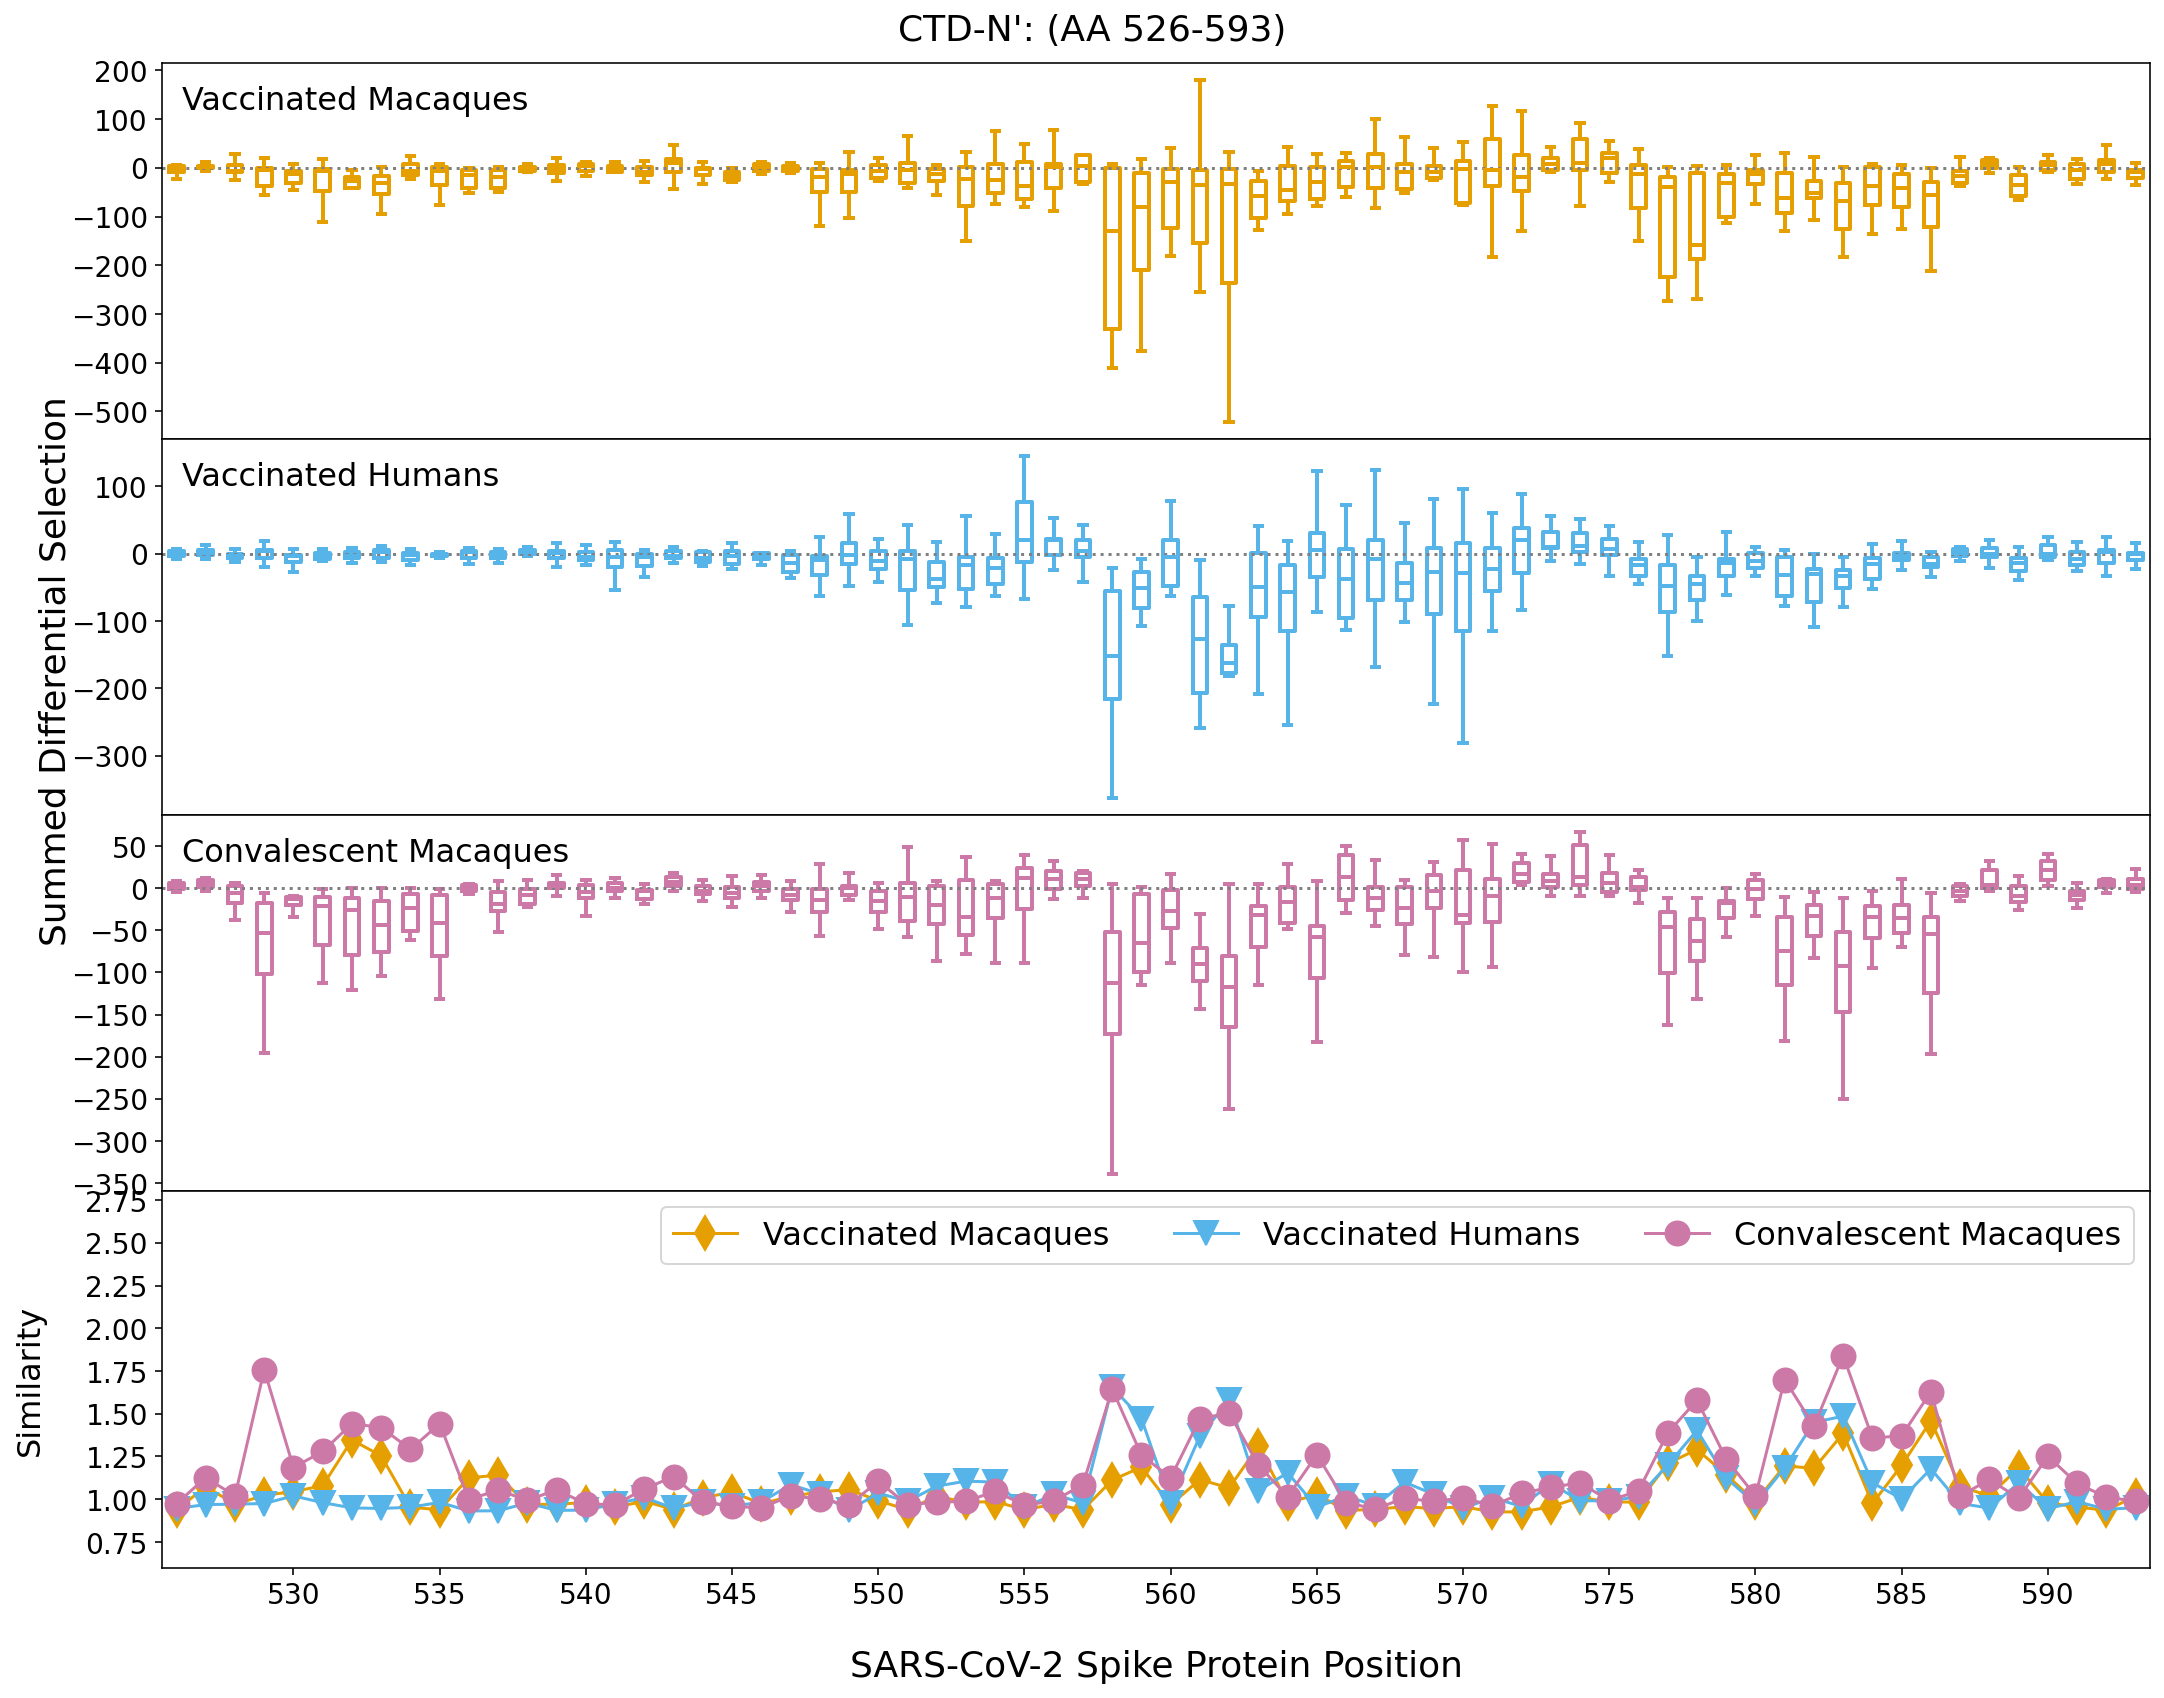

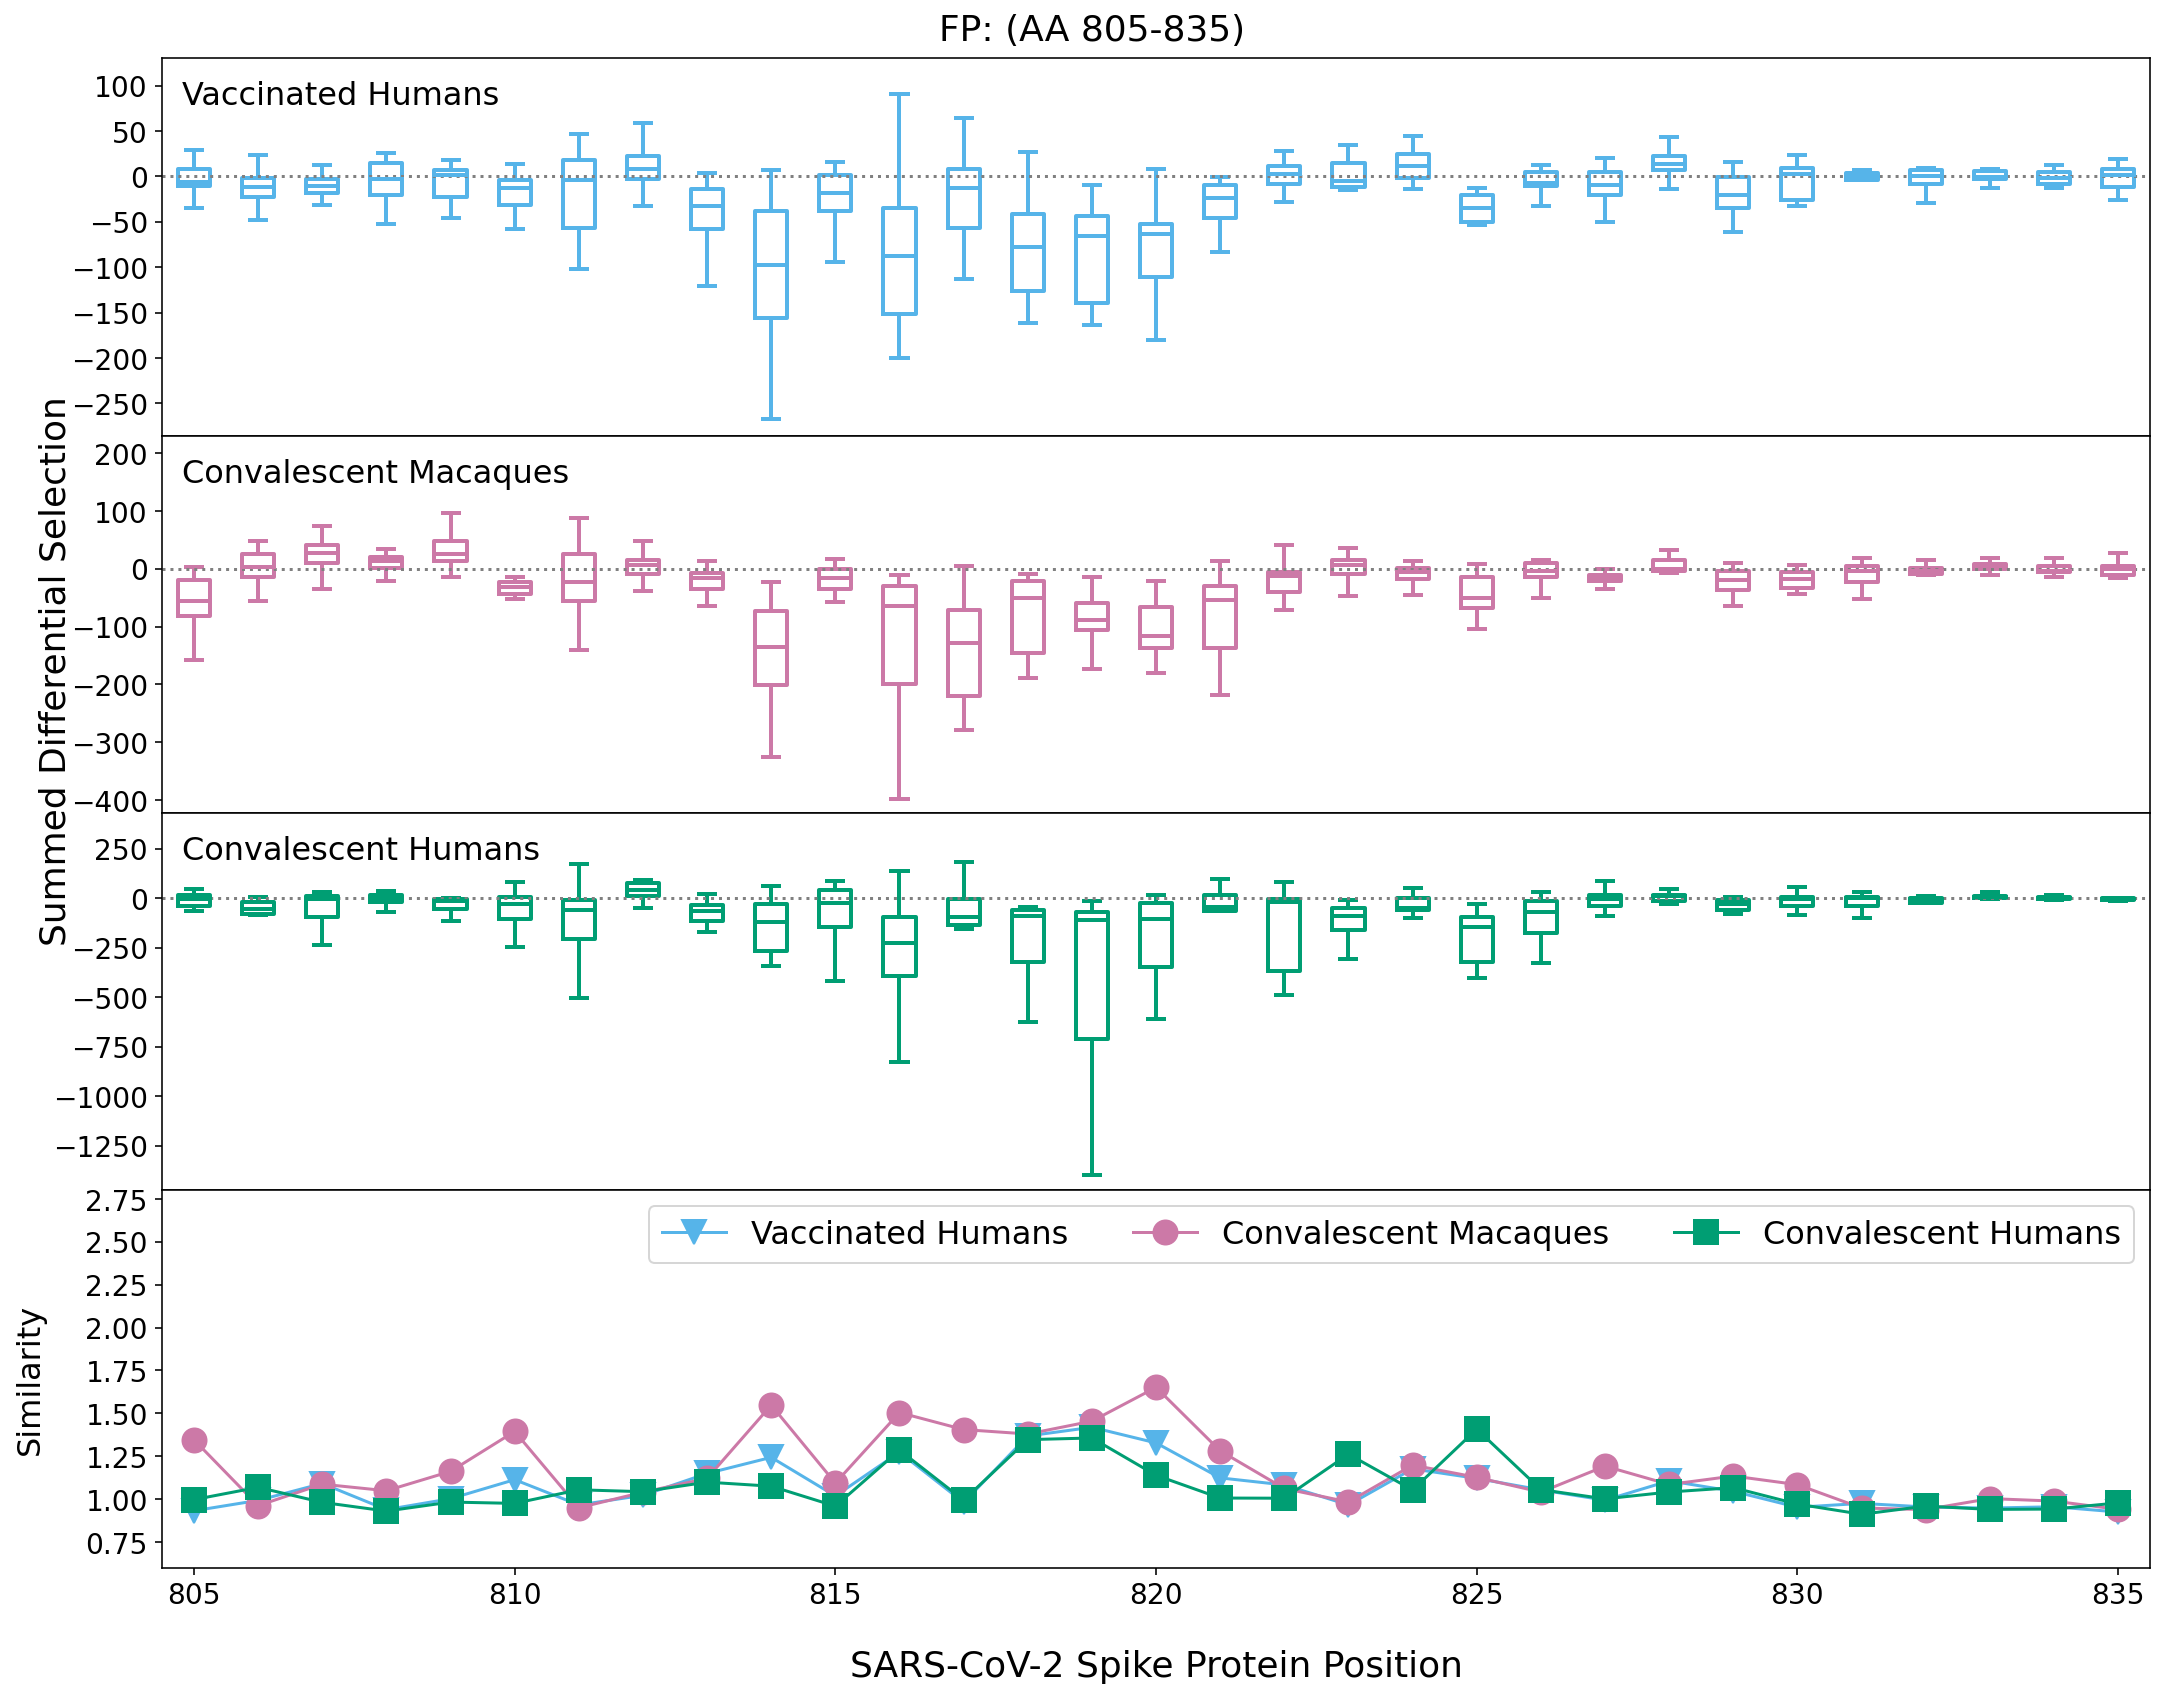

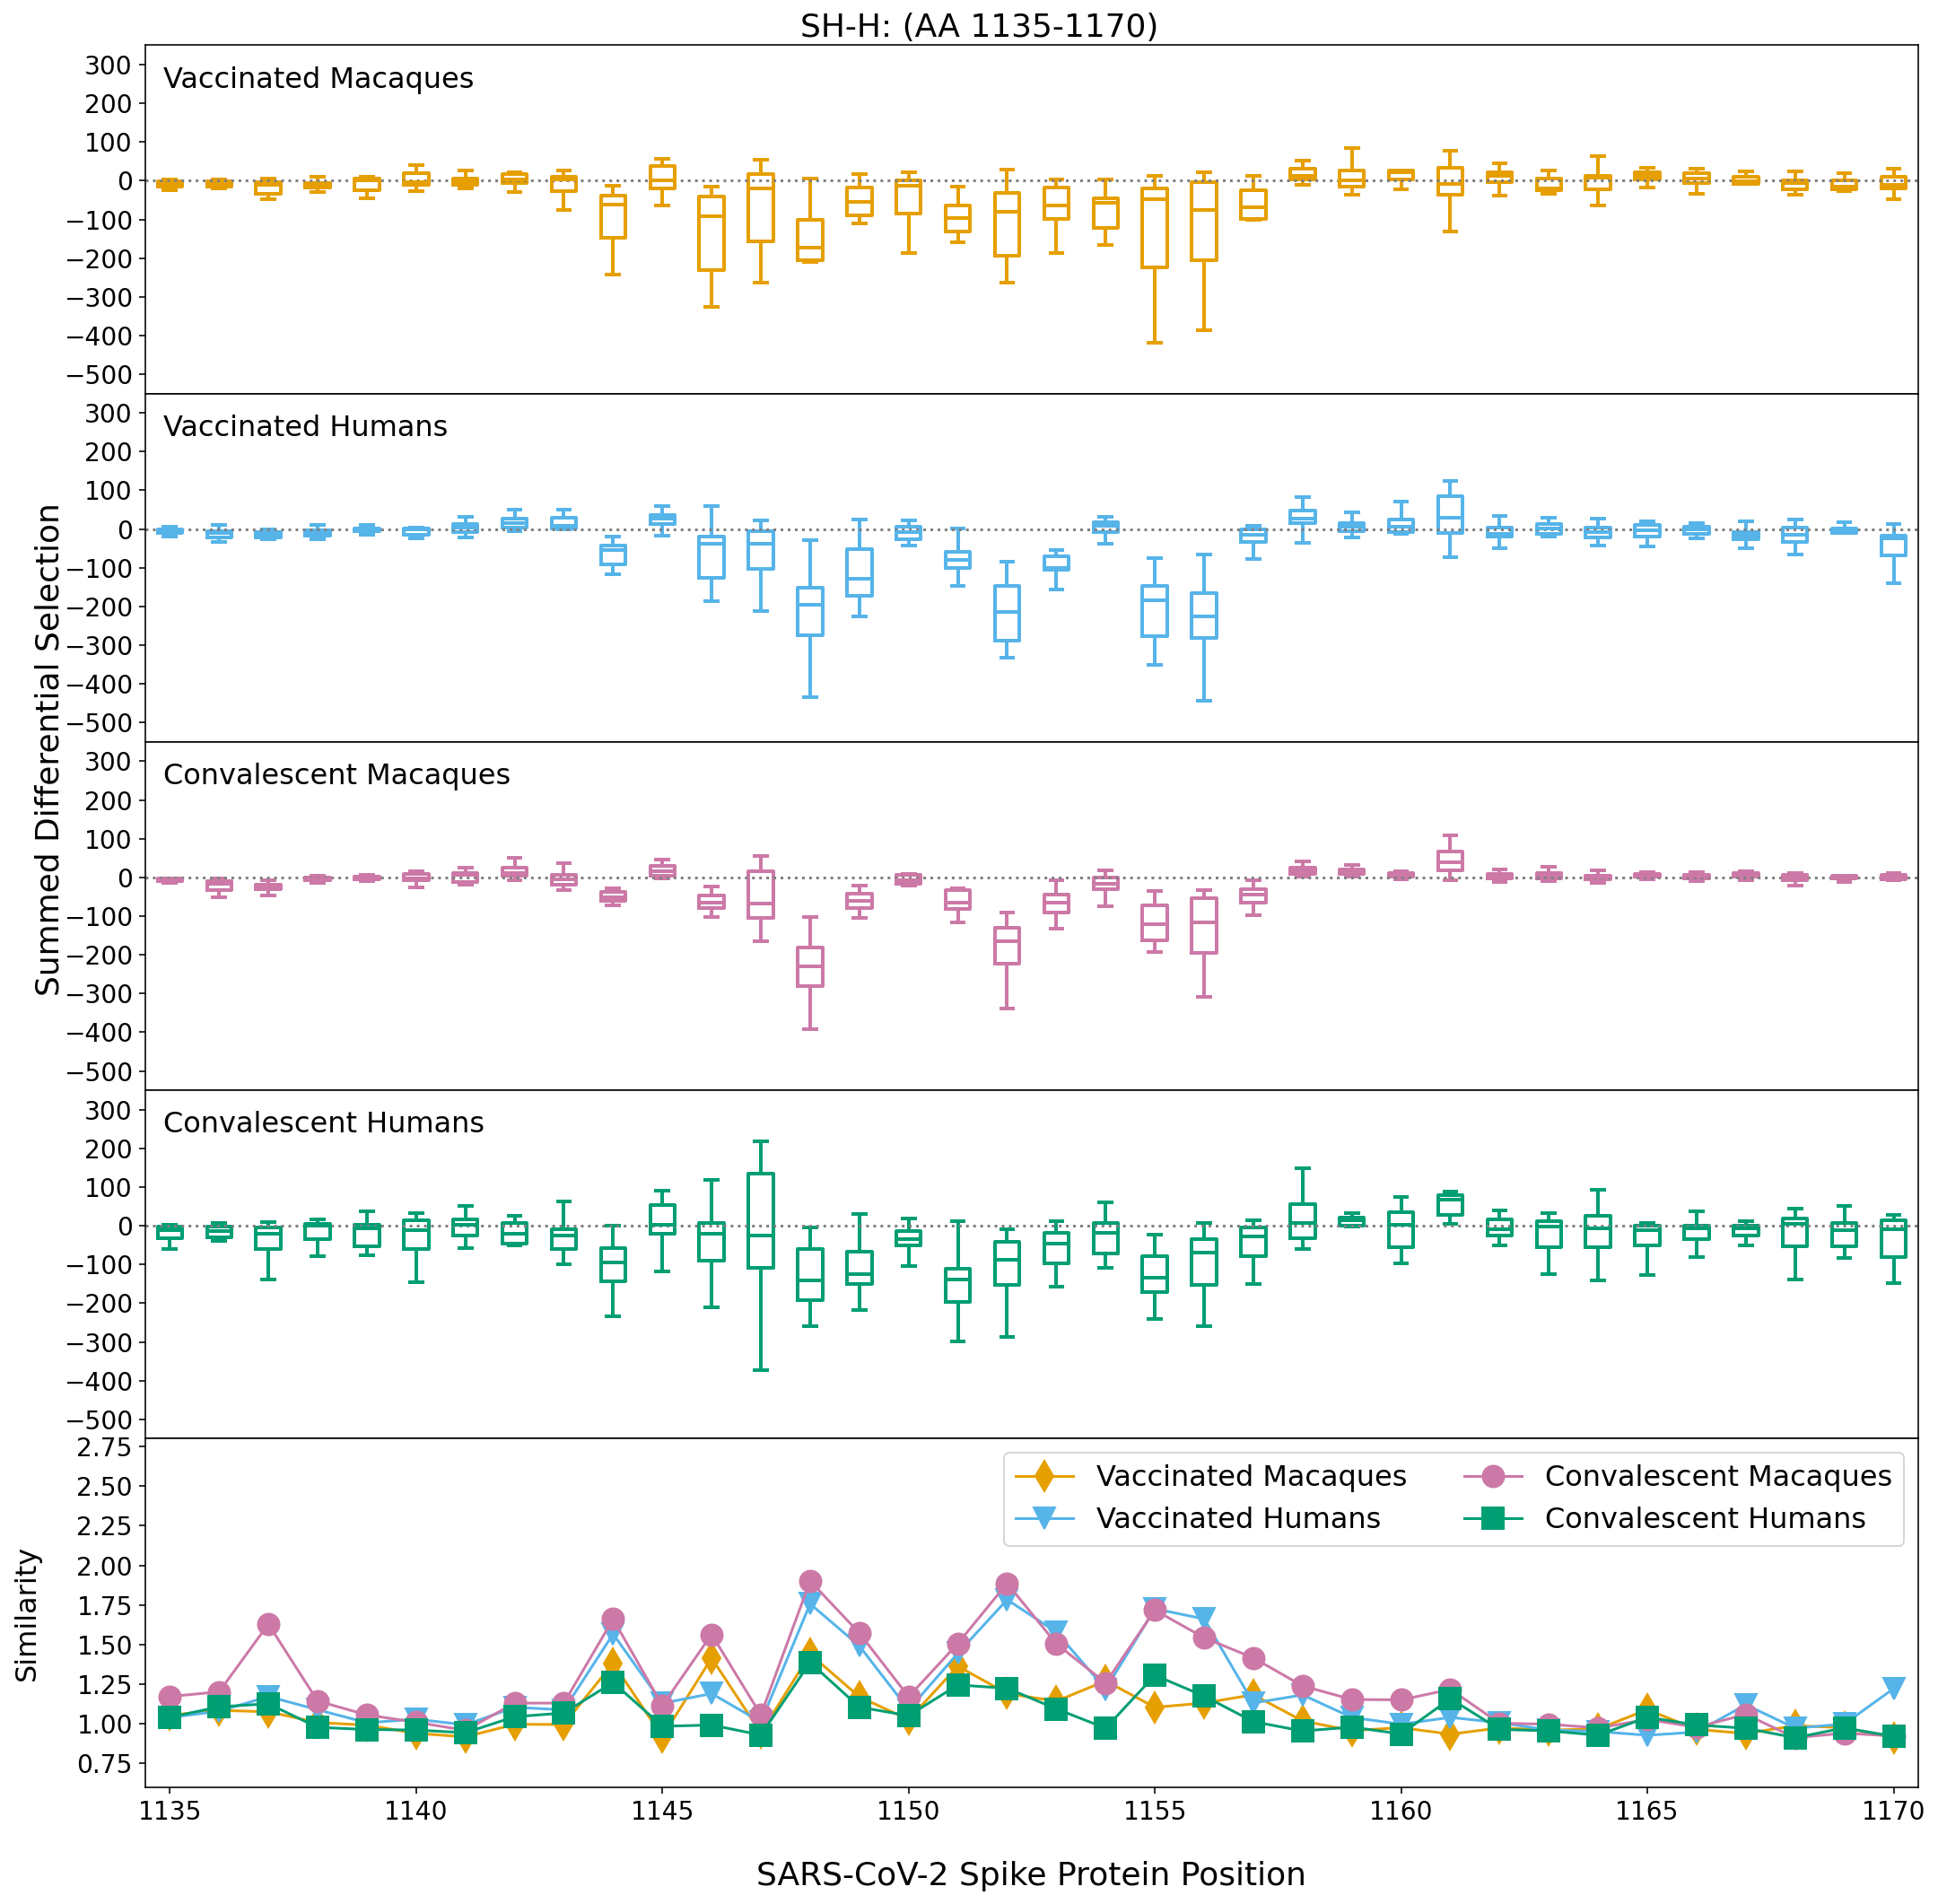

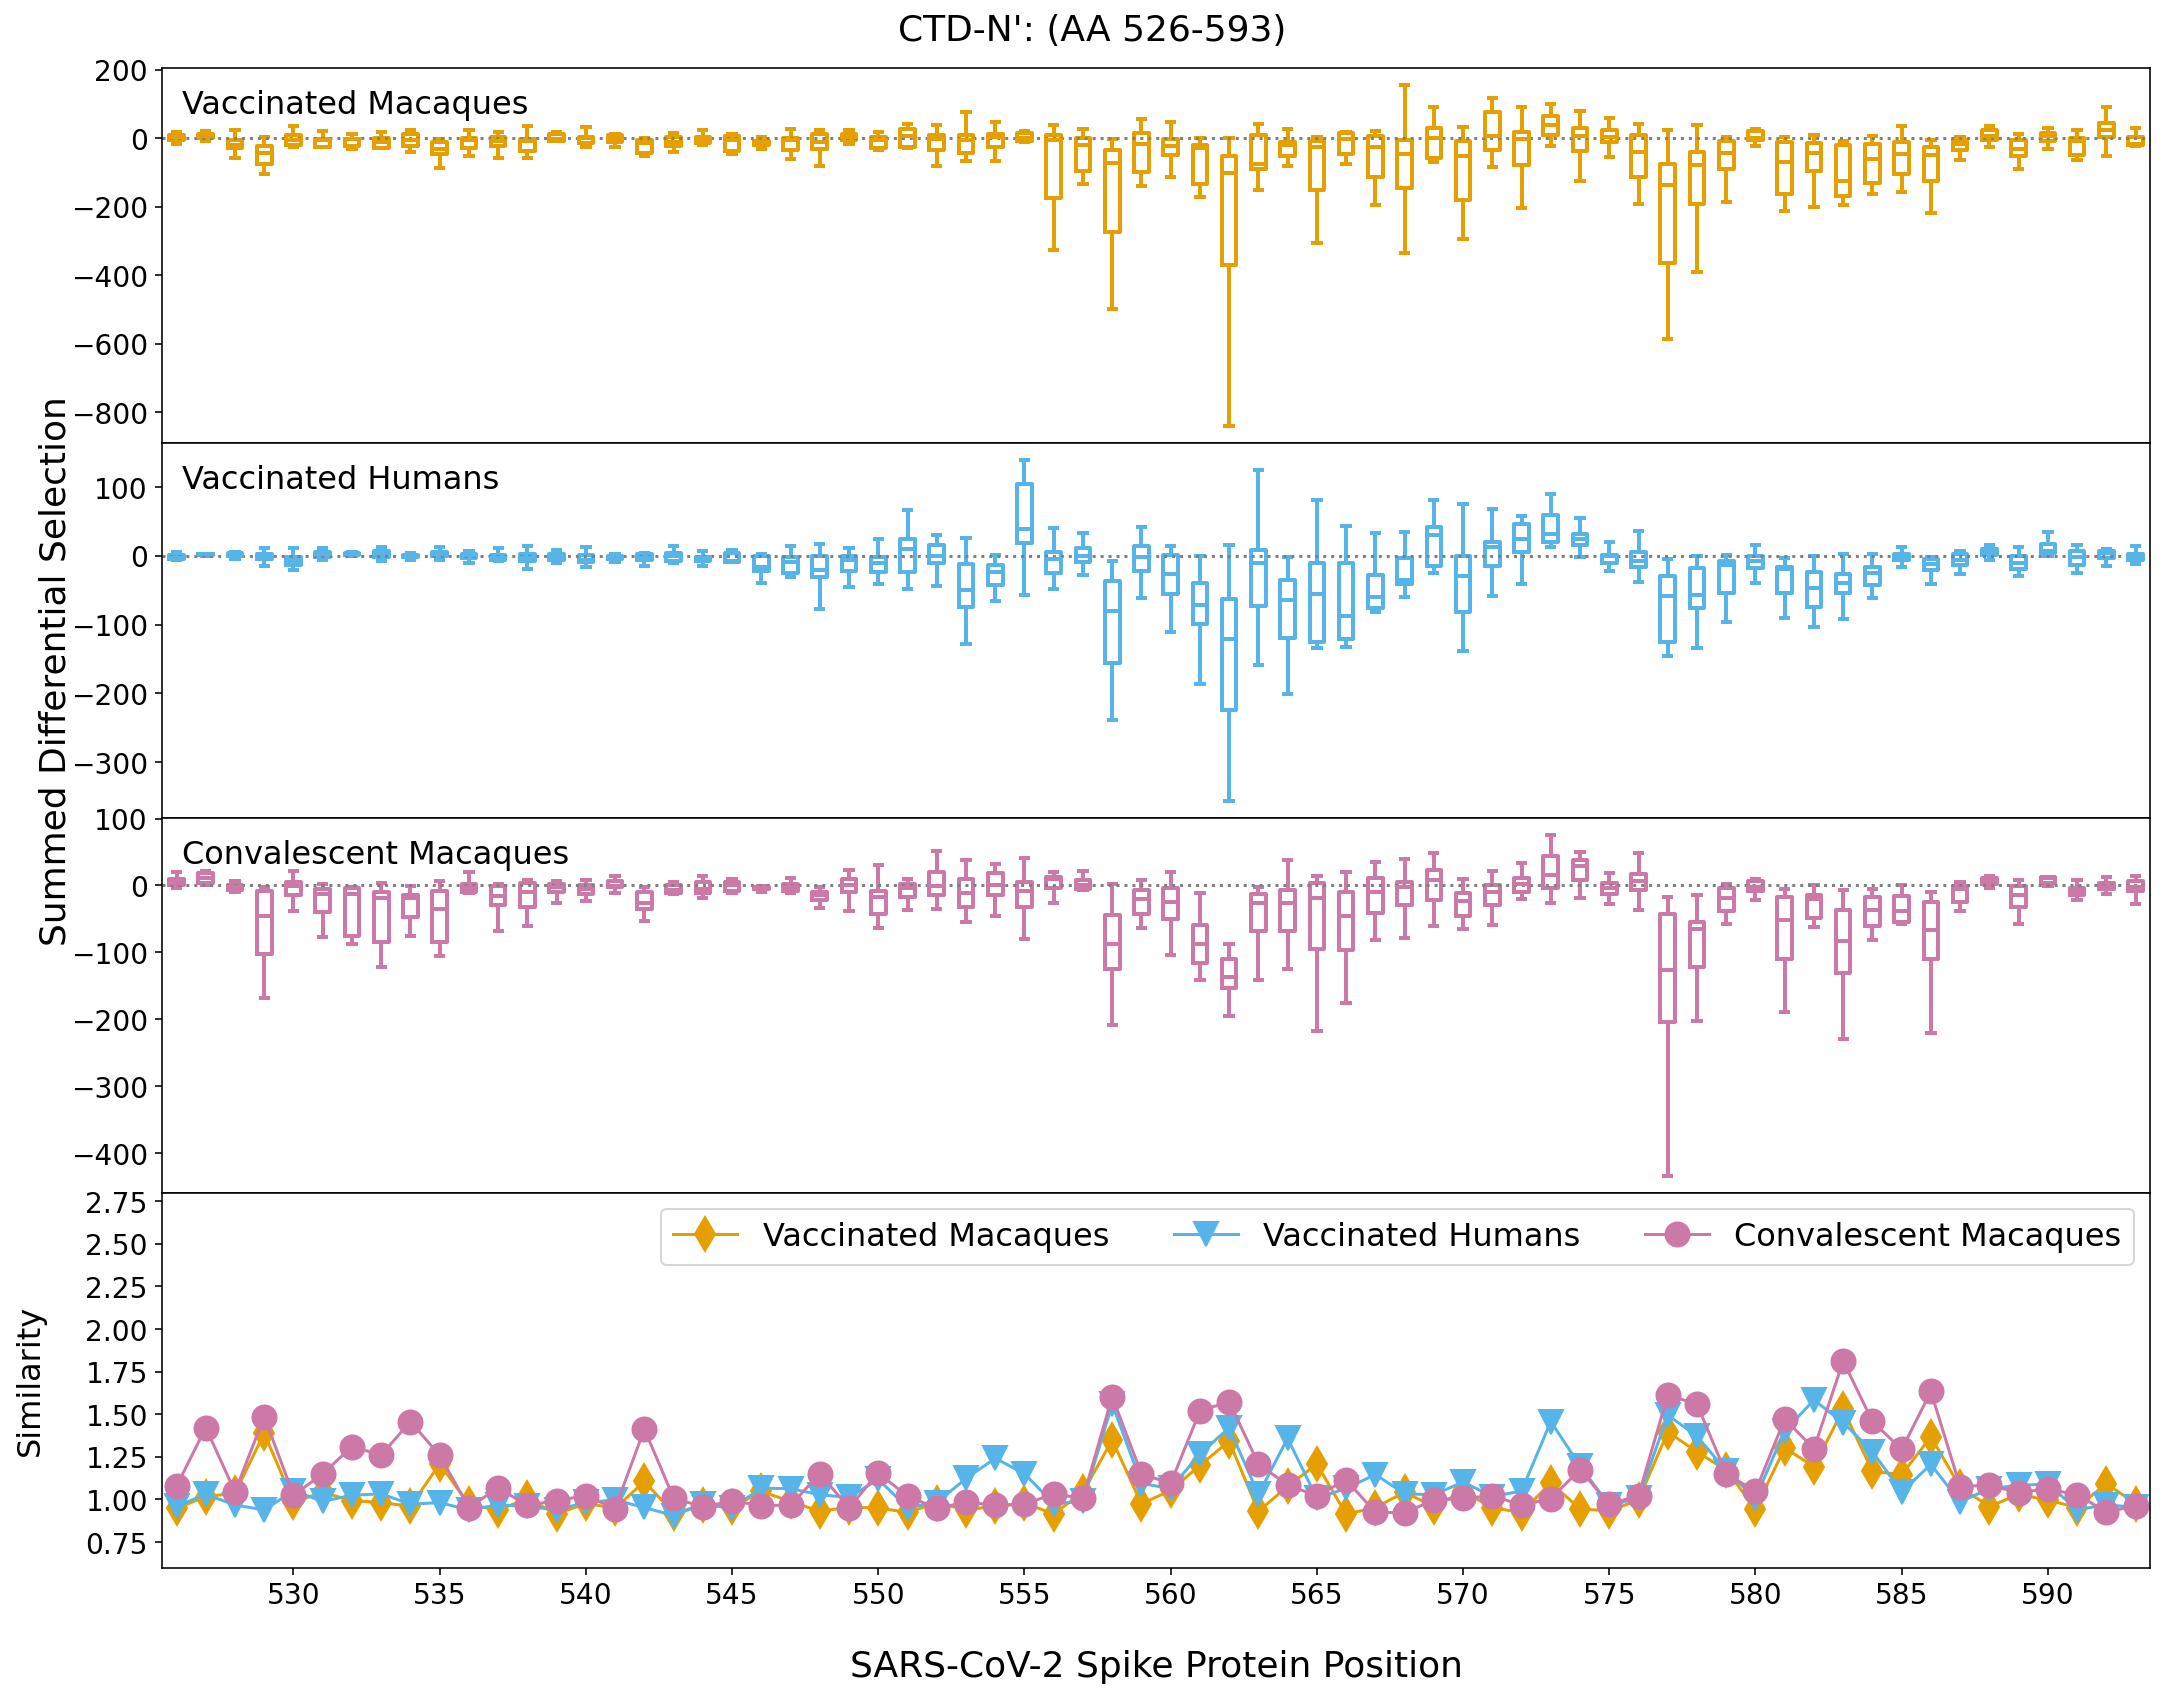

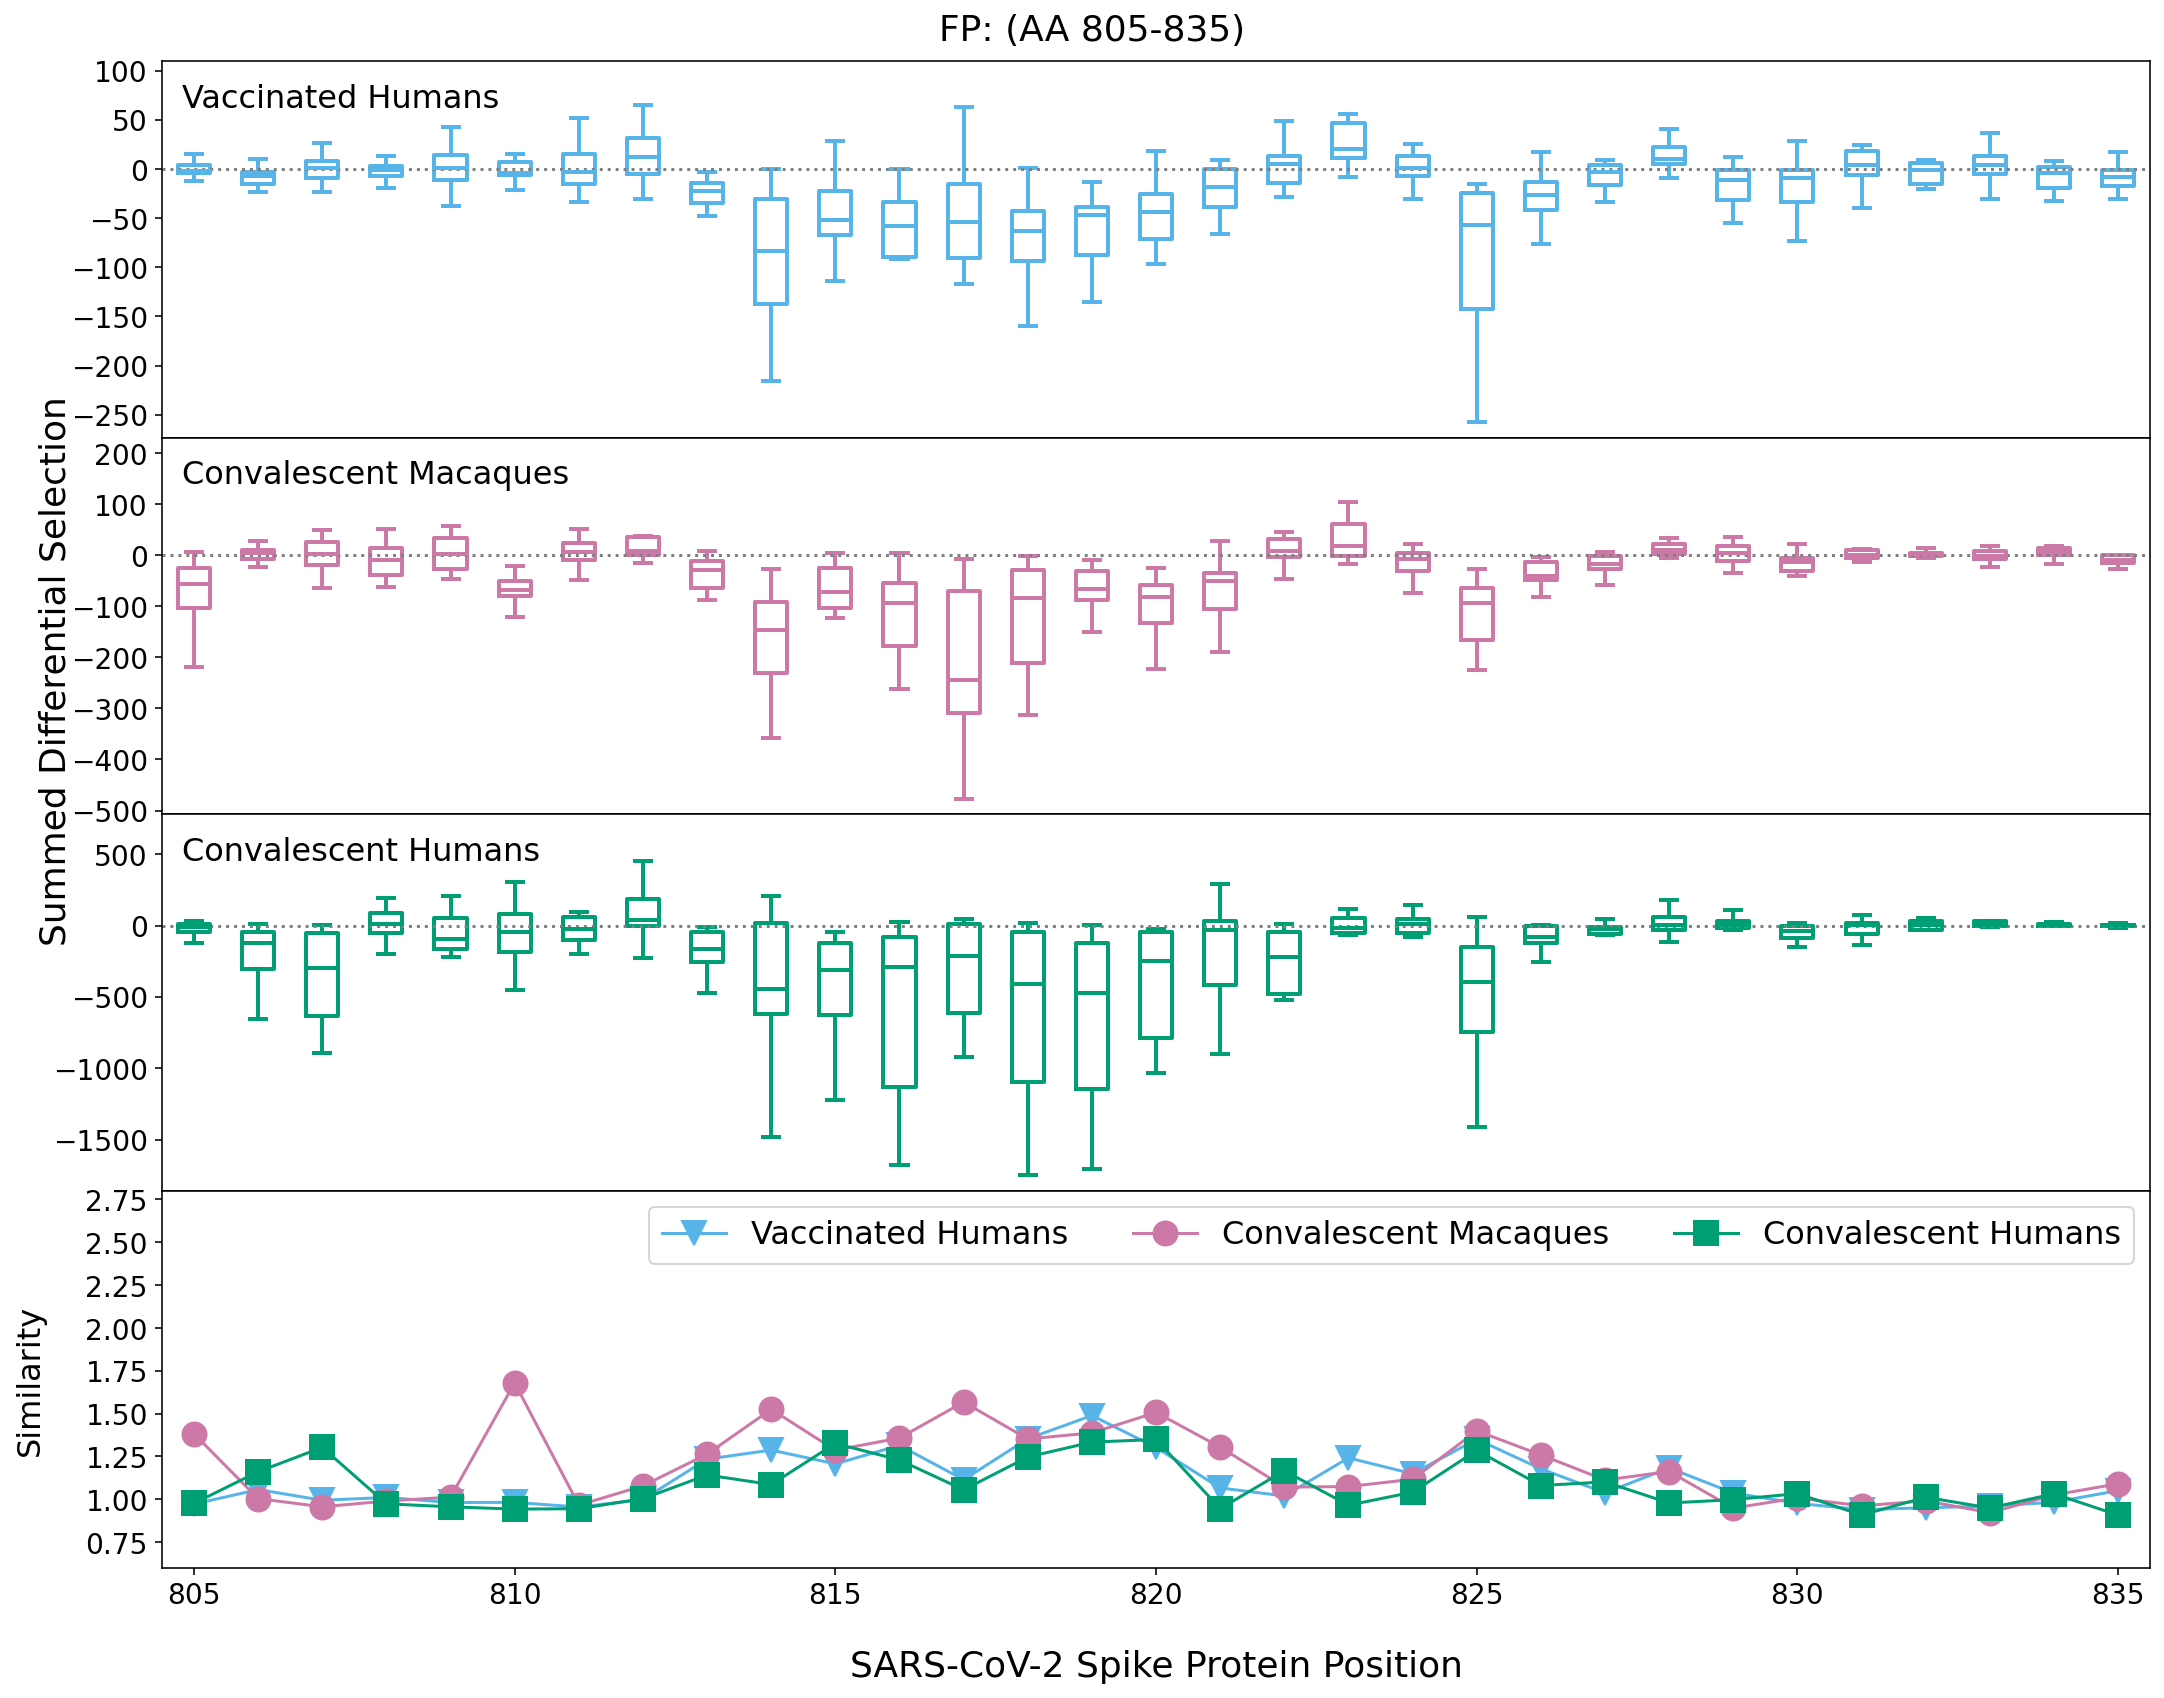

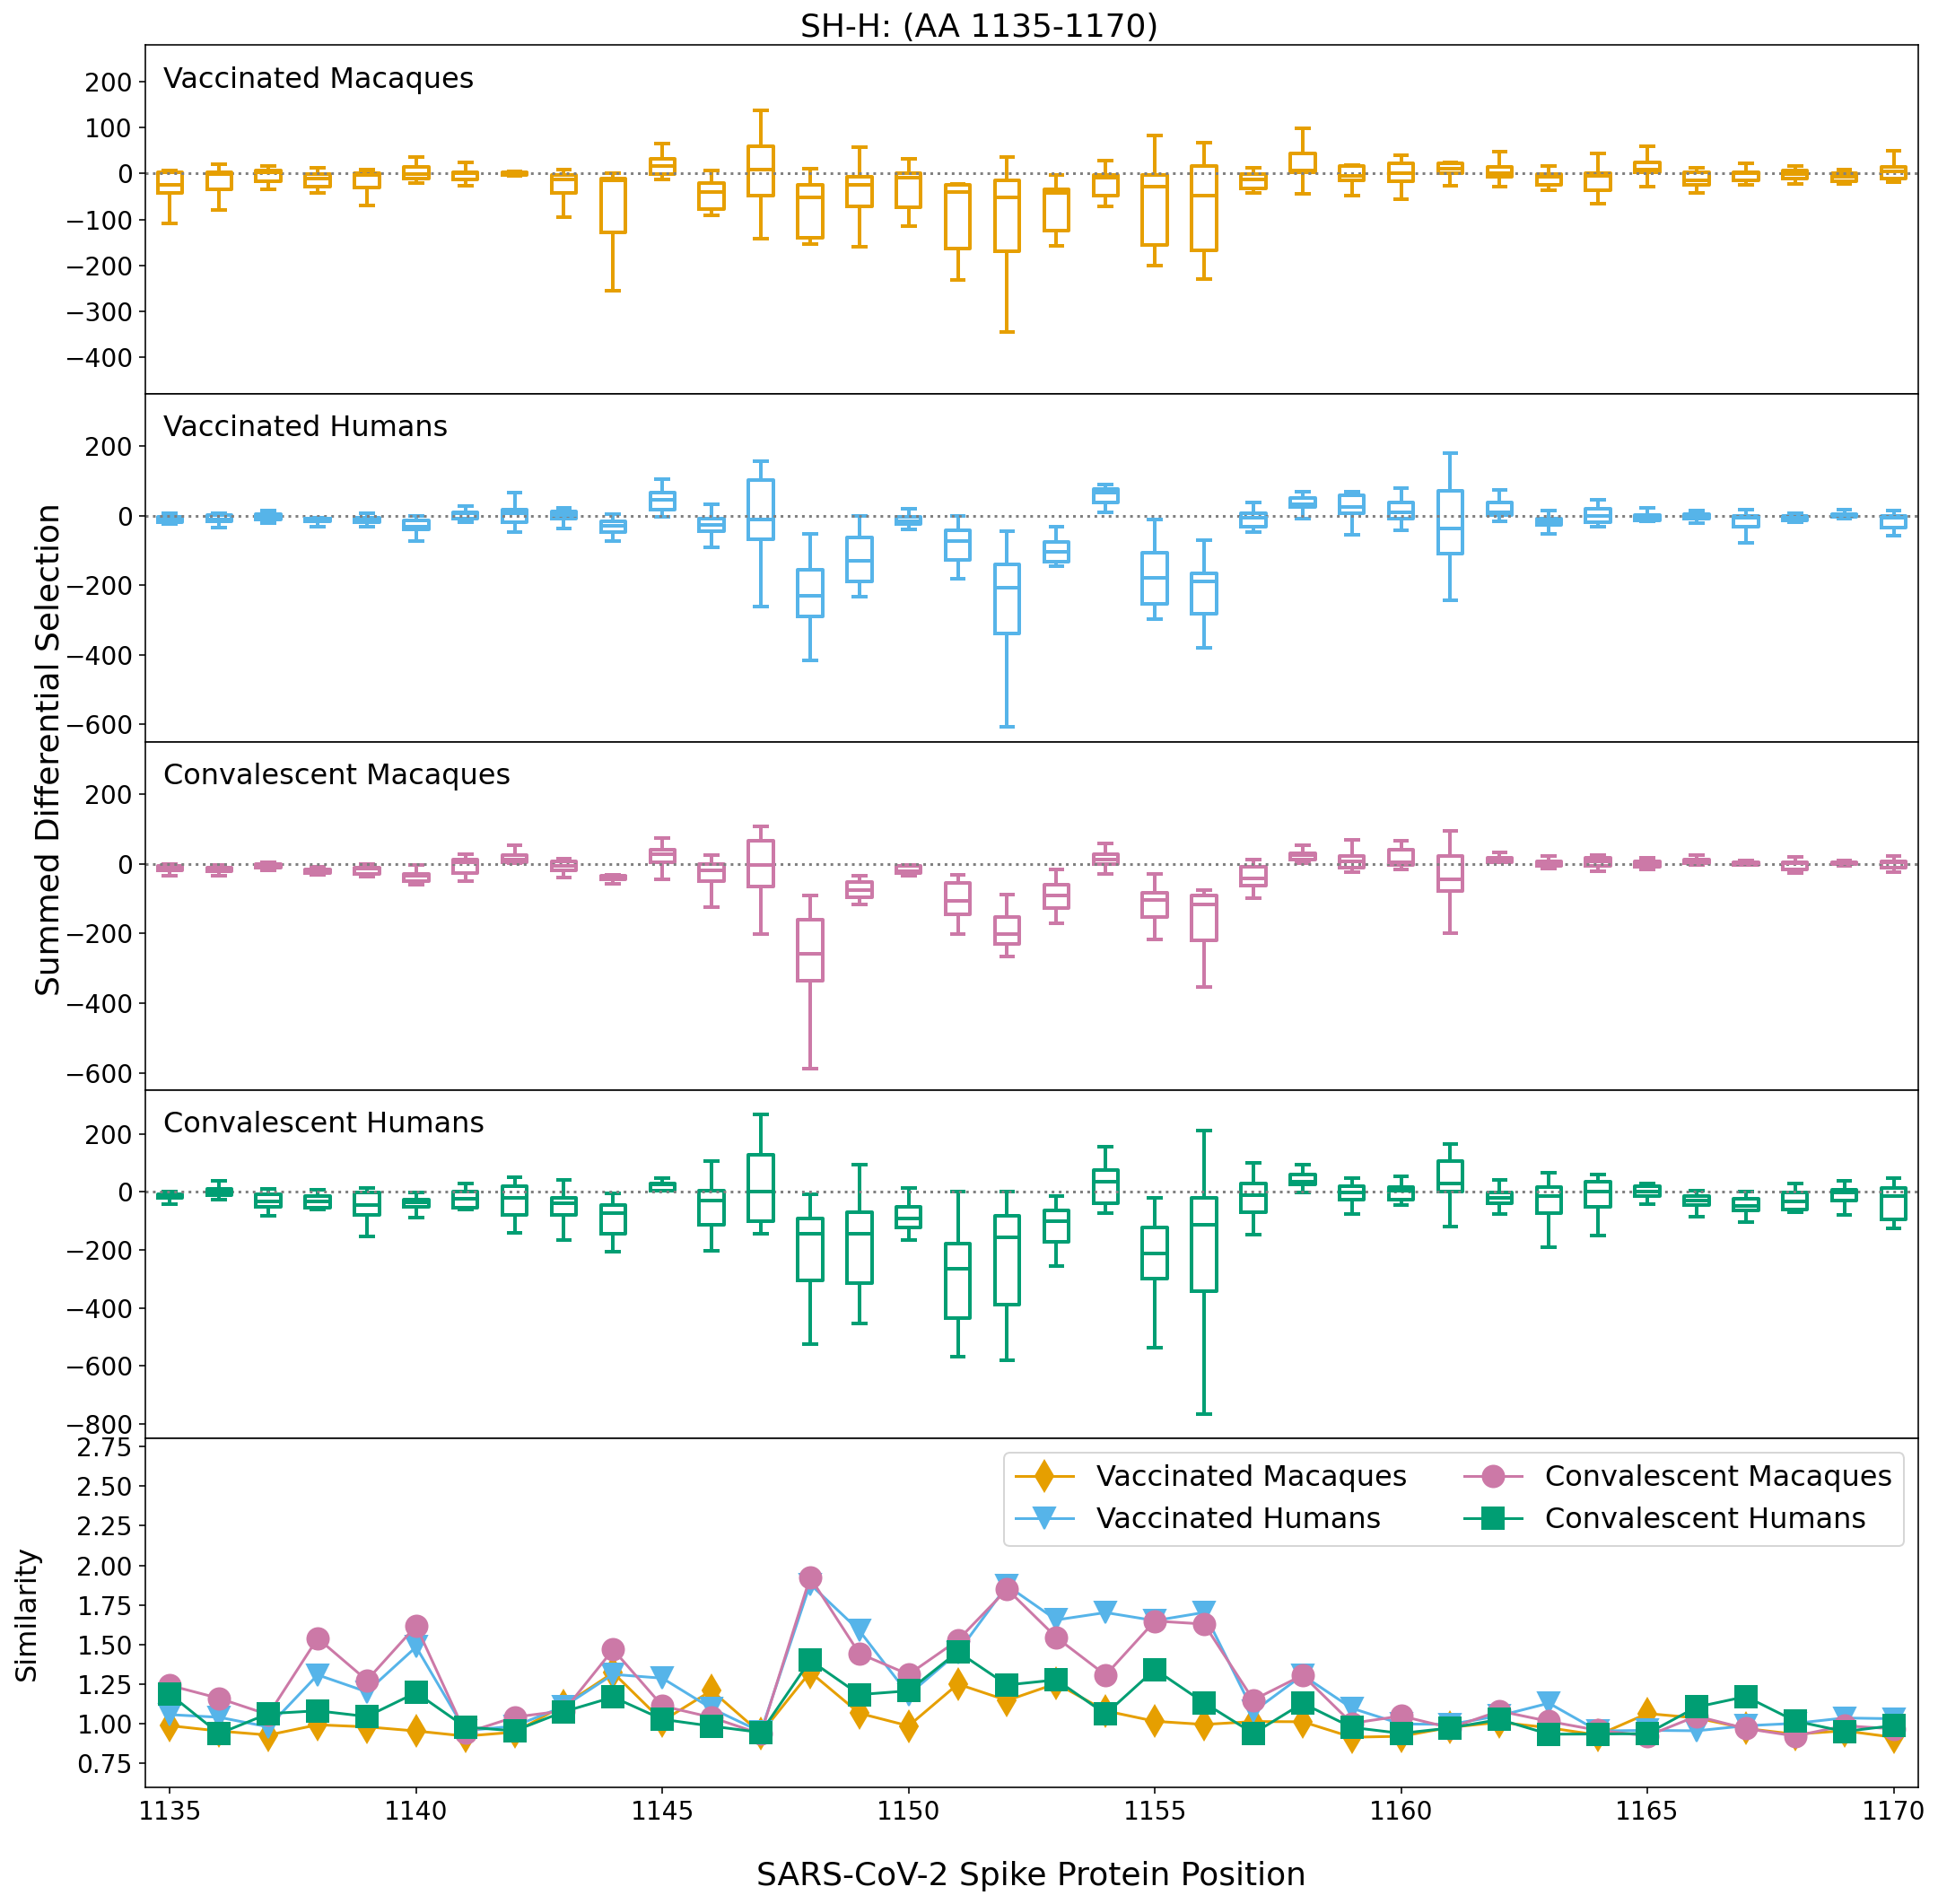

In [7]:
group_list  = [vaccinated_pigtail, moderna, convalescent_rhesus, conv_60d]
key_list    = ['vacc_macaques', 'vacc_humans', 'conv_macaques', 'conv_humans']
label_list  = ['Vaccinated Macaques', 'Vaccinated Humans', 'Convalescent Macaques', 'Convalescent Humans']
color_list  = [oi_orange, oi_skyblue, oi_reddishpurple, oi_bluishgreen]
marker_list = ['d', 'v', 'o', 's']

for batch in ['SPIKE2', 'SPIKE1']:
    outdir = f'{figdir}/{batch}'
    if not os.path.exists(outdir): os.mkdir(outdir)
    
    batch_samples = sample_id_coordinate_subset(phip_ds, where="library_batch", is_equal_to=batch)
    ds = phip_ds.loc[dict(sample_id=batch_samples)]

    for region in epitope_limits:
        region_groups_sums={}
        region_groups_sim={}

        for group, key in zip(group_list, key_list):
    
            region_sums, region_sim = analyze_region(ds,region,group)

            region_groups_sums[key] = copy.deepcopy(region_sums)
            region_groups_sim[key] = copy.deepcopy(region_sim)

        if region=='SHH':
            plotting_keys    = key_list
            plotting_labels  = label_list
            plotting_colors  = color_list
            plotting_markers = marker_list
            if batch=='SPIKE1':
                ymins = [-480, -650, -650, -850]
                ymaxs = [ 280,  350,  350,  350]
            else:
                ymins = [-550, -550, -550, -550]
                ymaxs = [ 350,  350,  350,  350]
            legncol = 2
            plotname = 'Figure_5A'
    
        elif region=='FP':
            plotting_keys    = key_list[1:]
            plotting_labels  = label_list[1:]
            plotting_colors  = color_list[1:]
            plotting_markers = marker_list[1:]
            if batch=='SPIKE1':
                ymins = []
                ymaxs = [110, 230, 780]
            else:
                ymins = []
                ymaxs = [130, 230, 430]
            legncol = 3
            plotname = 'Figure_4A'

        elif region=='CTDN':
            plotting_keys    = key_list[:-1]
            plotting_labels  = label_list[:-1]
            plotting_colors  = color_list[:-1]
            plotting_markers = marker_list[:-1]
            ymins = []
            ymaxs = []
            legncol = 3
            plotname = 'Figure_3A'
    
        plotting_sums=[]
        plotting_sim=[]
        for key in plotting_keys:
            plotting_sums.append(region_groups_sums[key])
            plotting_sim.append(region_groups_sim[key])    

        plot_sum_diff_sel_boxes(
            region_groups_sums = plotting_sums,
            region_groups_sim  = plotting_sim,
            groups_colors      = plotting_colors,
            groups_markers     = plotting_markers,
            groups_labels      = plotting_labels,
            region             = region,
            ymin_sums          = ymins,
            ymax_sums          = ymaxs,
            ymin_sim           = 0.6,
            ymax_sim           = 2.8,
            legncol            = legncol,
            draw               = True,
            out                = f'{outdir}/{plotname}.png'
        )